# Scrip para la competencia 01

## Notebook pipeline de entrenamiento y predicción

**DM EyF 2024**

Santiago Tedoldi

## Directorios

In [1]:
import os
import pandas as pd

datos = 'datos'

optimizacion = 'optimizacion'

modelos = 'modelos'

resultados = 'resultados'


### Condiciones de entrenamiento

Entrenamos con la mejor optimización posible, sobre el último més disponible.

Ya tenemos en nuestras variables, algunas variables históricas según el feature engineering aplicado.

In [2]:
ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202104

threshold = 0.025

semillas = [437809, 327347, 392879, 455783, 217163]

In [3]:
max_jobs = os.cpu_count() - 6

## Pipeline

Con distintos modelos

Se probó con modelos LightGBM y XGBoost

In [16]:
# Importar las librerías necesarias
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit, ShuffleSplit
from joblib import Parallel, delayed
import seaborn as sns
import matplotlib.pyplot as plt
import optuna

# Definir la clase ModelPipeline
class ModelPipeline:
    def __init__(self, data, seeds, model_type='decision_tree', 
                 ganancia_acierto=273000, costo_estimulo=7000, 
                 threshold=0.025, seed=0, n_jobs=-1, reg=False):
        self.data = data
        self.seeds = seeds
        self.s = seed
        self.n_jobs = int(n_jobs)
        self.model_type = model_type
        self.ganancia_acierto = ganancia_acierto
        self.costo_estimulo = costo_estimulo
        self.threshold = threshold
        self.reg = reg
        self.models = {}
        self.base_params = {'random_state': self.seeds[self.s]}
        self.best_params = None
        self.base_model = None
        self.best_model = None

        # Mapear model_type al clasificador correspondiente
        self.classifier_map = {
            'decision_tree': DecisionTreeClassifier,
            'random_forest': RandomForestClassifier,
            'xgboost': XGBClassifier,
            'lightgbm': LGBMClassifier
        }

    def def_xy(self, mes, target='clase_ternaria', to_pred=False):
        X = self.data[self.data['foto_mes'] == mes]
        y = X[target]
        X = X.drop(columns=[target])

        numero_de_cliente = X['numero_de_cliente']

        if to_pred:
            return X, numero_de_cliente
        else:
            return X, y

    def ganancia(self, model, X, y, prop=1):
        # Obtener las probabilidades predichas
        y_hat = model.predict_proba(X)

        # Obtener las clases del modelo
        model_classes = model.classes_

        # Identificar la clase objetivo (puede ser 'BAJA+2' o 2)
        if 'BAJA+2' in model_classes:
            target_class = 'BAJA+2'
        elif 2 in model_classes:
            target_class = 2
        else:
            raise ValueError("La clase objetivo 'BAJA+2' o 2 no está en las clases del modelo.")

        # Obtener el índice de la clase objetivo
        class_index = np.where(model_classes == target_class)[0][0]

        # Obtener las probabilidades predichas para la clase objetivo
        probs = y_hat[:, class_index]

        # Calcular la ganancia para cada fila
        gains = np.where(
            probs >= self.threshold,
            np.where(y == target_class, self.ganancia_acierto, -self.costo_estimulo),
            0
        )

        # Sumar las ganancias
        total_gain = gains.sum()/prop

        return total_gain

    def train_and_evaluate(self, train_index, test_index, X, y, params):
        # Instanciar el clasificador basado en model_type
        classifier_class = self.classifier_map[self.model_type]
        model = classifier_class(**params)
        model.fit(X.iloc[train_index], y.iloc[train_index])
        ganancia_value = self.ganancia(model, X.iloc[test_index], y.iloc[test_index], prop=0.3)
        return model, ganancia_value

    def optimize_model(self, X, y, storage_name, study_name, optimize=True, n_trials=200):
        sss_opt = ShuffleSplit(n_splits=5, test_size=0.3, random_state=self.seeds[self.s])

        def objective_xgboost(trial):
            # Hiperparámetros para XGBClassifier

            # Parámetros a optimizar
            # n_estimators = trial.suggest_int('n_estimators', 100, 500)
            max_leaves = trial.suggest_int('max_leaves', 10, 256)
            learning_rate = trial.suggest_float('eta', 0.01, 0.3, log=True)  # 'eta' es equivalente a 'learning_rate'
            gamma = trial.suggest_float('gamma', 0, 5)
            min_child_weight = trial.suggest_int('min_child_weight', 1, 10)
            subsample = trial.suggest_float('subsample', 0.5, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.5, 1.0)
            if self.reg:
                reg_lambda = trial.suggest_float('lambda', 0.0, 10.0)
                reg_alpha = trial.suggest_float('alpha', 0.0, 10.0)
            # scale_pos_weight = trial.suggest_float('scale_pos_weight', 1.0, 10.0)

            params = {
                'booster': 'gbtree',
                'n_estimators': 100,
                'max_leaves': max_leaves,
                'learning_rate': learning_rate,
                'gamma': gamma,
                'min_child_weight': min_child_weight,
                'subsample': subsample,
                'colsample_bytree': colsample_bytree,
                # 'scale_pos_weight': scale_pos_weight, # default = 1, ya que la ganancia ya contempla desbalance
                'random_state': self.seeds[self.s],
                'enable_categorical': True,
                'use_label_encoder': False,
                'objective': 'multi:softprob',
                'num_class': 3,
                'eval_metric': 'mlogloss',
                'tree_method': 'hist',      # Usar 'hist' para grandes conjuntos de datos
                'grow_policy': 'lossguide', # Necesario cuando se usa 'max_leaves'
            }

            if self.reg:
                params.update({
                    'reg_lambda': reg_lambda,  # 'lambda' es palabra reservada en Python, usamos 'reg_lambda'
                    'reg_alpha': reg_alpha,
                })

            # Ejecutar validación cruzada paralela
            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.train_and_evaluate)(train_index, test_index, X, y, params)
                for train_index, test_index in sss_opt.split(X, y)
            )

            # Retornar la ganancia media
            return np.mean([result[1] for result in results])

        def objective_lightgbm(trial):
            # Hiperparámetros para LGBMClassifier
            # n_estimators = trial.suggest_int('n_estimators', 100, 1000)
            num_leaves = trial.suggest_int('num_leaves', 31, 256)
            # max_depth = trial.suggest_int('max_depth', -1, 30) # conflict with num_leaves
            learning_rate = trial.suggest_float('learning_rate', 0.001, 0.3, log=True)
            min_data_in_leaf = trial.suggest_int('min_data_in_leaf', 20, 100)
            if self.reg:
                lambda_l1 = trial.suggest_float('lambda_l1', 0.0, 10.0)
                lambda_l2 = trial.suggest_float('lambda_l2', 0.0, 10.0)
            min_gain_to_split = trial.suggest_float('min_gain_to_split', 0.0, 1.0)
            feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
            bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
            bagging_freq = trial.suggest_int('bagging_freq', 1, 7)
            max_bin = trial.suggest_int('max_bin', 64, 255)

            params = {
                'n_estimators': 100, # to reduce overfitting and training time
                'num_leaves': num_leaves,
                # 'max_depth': max_depth,
                'learning_rate': learning_rate,
                'min_data_in_leaf': min_data_in_leaf,
                'min_gain_to_split': min_gain_to_split,
                'feature_fraction': feature_fraction,
                'bagging_fraction': bagging_fraction,
                'bagging_freq': bagging_freq,
                'max_bin': max_bin,
                # 'objective': 'binary',  # Specify the objective function
                # 'metric': 'binary_logloss',  # Specify the evaluation metric
                'random_state': self.seeds[self.s],
                'n_jobs': self.n_jobs
            }

            if self.reg:
                params.update({
                    'lambda_l1': lambda_l1,
                    'lambda_l2': lambda_l2,
                })

            results = Parallel(n_jobs=self.n_jobs)(
                delayed(self.train_and_evaluate)(train_index, test_index, X, y, params)
                for train_index, test_index in sss_opt.split(X)
            )

            return np.mean([result[1] for result in results])

        # Mapear model_type a la función objetivo correspondiente
        objective_map = {
            'xgboost': objective_xgboost,
            'lightgbm': objective_lightgbm
        }

        objective = objective_map[self.model_type]

        study = optuna.create_study(
            direction="maximize",
            study_name=study_name,
            storage=storage_name,
            load_if_exists=True
        )

        if optimize:
            print(f"Optimizando {self.model_type} con {n_trials} pruebas")
            study.optimize(objective, n_trials=n_trials)

        best_trial = study.best_trial
        self.best_params = best_trial.params  # Guardar los mejores parámetros

        print(f"Mejores parámetros para {self.model_type}: {best_trial.params}")
        return best_trial.params

    def train_base_model(self, X_train, y_train):
        classifier_class = self.classifier_map[self.model_type]
        self.base_model = classifier_class(**self.base_params)
        self.base_model.fit(X_train, y_train)

    def train_best_model(self, X_train, y_train):
        if self.best_params is None:
            print("No se encontraron mejores parámetros. Por favor, ejecuta optimize_model primero.")
            return
        classifier_class = self.classifier_map[self.model_type]
        self.best_model = classifier_class(**self.best_params)
        self.best_model.fit(X_train, y_train)

    def compare_models(self, X, y):
        sss = StratifiedShuffleSplit(n_splits=30, test_size=0.3, random_state=self.seeds[self.s])

        results_base = Parallel(n_jobs=self.n_jobs)(
            delayed(self.train_and_evaluate)(train_index, test_index, X, y, self.base_params)
            for train_index, test_index in sss.split(X, y)
        )
        results_best = Parallel(n_jobs=self.n_jobs)(
            delayed(self.train_and_evaluate)(train_index, test_index, X, y, self.best_params)
            for train_index, test_index in sss.split(X, y)
        )

        return results_base, results_best

    def plot_comparisons(self, results_base, results_best):
        df_pred = pd.DataFrame({'Ganancia': [result[1] for result in results_base], 'Modelo': 'Base'})
        df_pred_best = pd.DataFrame({'Ganancia': [result[1] for result in results_best], 'Modelo': 'Best'})
        df_combined = pd.concat([df_pred, df_pred_best])

        g = sns.FacetGrid(df_combined, row="Modelo", aspect=2)
        g.map(sns.histplot, "Ganancia", kde=True)
        plt.show()

        mean_base = df_combined[df_combined['Modelo'] == 'Base']['Ganancia'].mean()
        mean_best = df_combined[df_combined['Modelo'] == 'Best']['Ganancia'].mean()

        print(f"Ganancia media del modelo base: {mean_base}")
        print(f"Ganancia media del modelo Best: {mean_best}")

    def test_model(self, model, X, y):
        ganancia_test = self.ganancia(model, X, y)
        print(f"Ganancia del modelo en el conjunto de test: {ganancia_test}")
        return ganancia_test

    def test_base_model(self, X, y):
        return self.test_model(self.base_model, X, y)

    def test_best_model(self, X, y):
        return self.test_model(self.best_model, X, y)

    def simulate_kaggle_split(self, mes_futuro, imputer=None):
        """
        Simula el split público/privado como en una competencia de Kaggle.
        """
        # Obtener los datos futuros
        X_futuro, y_futuro = self.def_xy(mes_futuro, target='clase_ternaria', to_pred=False)
        if imputer is not None:
            X_futuro = pd.DataFrame(imputer.fit_transform(X_futuro), columns=X_futuro.columns)

        # Simular el split público/privado
        sss_futuro = StratifiedShuffleSplit(n_splits=50, test_size=0.3, random_state=self.seeds[self.s])

        ganancias_futuro_privada_best = []
        ganancias_futuro_privada_base = []
        ganancias_futuro_publica_best = []
        ganancias_futuro_publica_base = []

        for train_index, test_index in sss_futuro.split(X_futuro, y_futuro):
            # Privado (70% de los datos)
            ganancias_futuro_privada_best.append(
                self.ganancia(self.best_model, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7)
            )
            ganancias_futuro_privada_base.append(
                self.ganancia(self.base_model, X_futuro.iloc[train_index], y_futuro.iloc[train_index], prop=0.7)
            )
            # Público (30% de los datos)
            ganancias_futuro_publica_best.append(
                self.ganancia(self.best_model, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3)
            )
            ganancias_futuro_publica_base.append(
                self.ganancia(self.base_model, X_futuro.iloc[test_index], y_futuro.iloc[test_index], prop=0.3)
            )

        # Crear DataFrames para visualización
        df_pred_1_best = pd.DataFrame({
            'Ganancia': ganancias_futuro_privada_best,
            'Modelo': 'Best',
            'Grupo': 'Privado'
        })
        df_pred_2_best = pd.DataFrame({
            'Ganancia': ganancias_futuro_publica_best,
            'Modelo': 'Best',
            'Grupo': 'Publico'
        })
        df_pred_1_base = pd.DataFrame({
            'Ganancia': ganancias_futuro_privada_base,
            'Modelo': 'Base',
            'Grupo': 'Privado'
        })
        df_pred_2_base = pd.DataFrame({
            'Ganancia': ganancias_futuro_publica_base,
            'Modelo': 'Base',
            'Grupo': 'Publico'
        })

        df_combined = pd.concat([df_pred_1_base, df_pred_2_base, df_pred_1_best, df_pred_2_best])

        # Visualización
        g = sns.FacetGrid(df_combined, col="Grupo", row="Modelo", aspect=2)
        g.map(sns.histplot, "Ganancia", kde=True)
        plt.show()

        # Cálculo de ganancias medias
        mean_base_privado = df_combined[
            (df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Privado')
        ]['Ganancia'].mean()
        mean_base_publico = df_combined[
            (df_combined['Modelo'] == 'Base') & (df_combined['Grupo'] == 'Publico')
        ]['Ganancia'].mean()
        mean_best_privado = df_combined[
            (df_combined['Modelo'] == 'Best') & (df_combined['Grupo'] == 'Privado')
        ]['Ganancia'].mean()
        mean_best_publico = df_combined[
            (df_combined['Modelo'] == 'Best') & (df_combined['Grupo'] == 'Publico')
        ]['Ganancia'].mean()

        print(f"Ganancia media del modelo base en privado: {mean_base_privado}")
        print(f"Ganancia media del modelo base en público: {mean_base_publico}")
        print(f"Ganancia media del modelo Best en privado: {mean_best_privado}")
        print(f"Ganancia media del modelo Best en público: {mean_best_publico}")

_____

## LightGBM 

**Aggressive FE 3 + data cleansing**

La creación del target y el análisis exploratorio, está avanzado en el Notebook_comp01.

Luego, un proceso de **feature engineering conceptual y extendido a 3 meses previos**, fue llevado a cabo en el Notebook_comp01_fe_agr_3.

Agrego, la eliminación de features conflictivas.

### Datos

In [5]:
dataset_file = 'competencia_01_brandoni_fe_agr_3.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

C:\Users\santt\AppData\Local\Temp\ipykernel_15848\3305751415.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


### Data Quality

In [6]:
mes_train = 202104
mes_score = 202106 # a predecir

train_data = data[data['foto_mes'] == mes_train]
score_data = data[data['foto_mes'] == mes_score]

Nulls

In [14]:
train_null_percentage = train_data.isnull().mean() * 100
score_null_percentage = score_data.isnull().mean() * 100

comparison_df = pd.DataFrame({'Train Null Percentage': train_null_percentage, 'Score Null Percentage': score_null_percentage})
comparison_df['diff'] = (comparison_df['Score Null Percentage'] - comparison_df['Train Null Percentage']).abs()

comparison_df_sorted = comparison_df.sort_values('diff', ascending=False)
comparison_df_sorted.head(10)

,Train Null Percentage,Score Null Percentage,diff
clase_ternaria,0.000000,100.000000,100.000000
Master_cconsumos,59.780608,58.459691,1.320917
Master_mconsumospesos,59.780608,58.459691,1.320917
Master_mconsumosdolares,59.780608,58.459691,1.320917
Master_madelantopesos,59.780608,58.459691,1.320917
Master_madelantodolares,59.780608,58.459691,1.320917
Master_mpagospesos,59.780608,58.459691,1.320917
Master_mpagosdolares,59.780608,58.459691,1.320917
Master_mconsumototal,59.780608,58.459691,1.320917
Master_cadelantosefectivo,59.780608,58.459691,1.320917


Parece necesario trabajar sobre la imputación de nulos

Sin embargo, tanto el mes de entrenamiento como el mes a predecir tienen porcentajes similares de nulos.

In [ ]:
### Imputación

Zeros

In [15]:
train_zero_percentage = (train_data == 0).mean() * 100
score_zero_percentage = (score_data == 0).mean() * 100

comparison_df_zero = pd.DataFrame({'Train Zero Percentage': train_zero_percentage, 'Score Zero Percentage': score_zero_percentage})
comparison_df_zero['diff_zero_percentage'] = (comparison_df_zero['Score Zero Percentage'] - comparison_df_zero['Train Zero Percentage']).abs()

diff_zero_percentage_sorted = comparison_df_zero.sort_values('diff_zero_percentage',ascending=False)
diff_zero_percentage_sorted.head(10)

,Train Zero Percentage,Score Zero Percentage,diff_zero_percentage
Master_fultimo_cierre,0.000000,68.891773,68.891773
Visa_fultimo_cierre,0.000000,68.829909,68.829909
comisiones_mantenimiento_slope_2_foto_mes,71.456518,91.896334,20.439816
comisiones_mantenimiento_slope_2_cliente_antiguedad,71.456518,91.895728,20.439210
comisiones_mantenimiento_slope_3_foto_mes,69.519166,85.364152,15.844986
comisiones_mantenimiento_slope_3_cliente_antiguedad,69.519166,85.363546,15.844380
delta_2_comisiones_mantenimiento,67.584253,82.907761,15.323508
delta_3_comisiones_mantenimiento,66.220976,80.476237,14.255260
lag_2_cuenta_corriente,51.619843,46.652636,4.967207
delta_1_comisiones_mantenimiento,91.550369,86.690604,4.859765


['Master_fultimo_cierre', 'Visa_fultimo_cierre'] parecen tener una gran diferencia entre el mes de entrenamiento y el mes a predecir.

Las subsiguientes features presentan una situación a analizar.

In [17]:
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre']

### Data Drifting

Analizado por el Profesor

In [18]:
to_drop = to_drop + ['cprestamos_personales', 'mprestamos_personales']

Uso del pipeline con LightGBM

En abril

Sin mes_test

In [19]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con LightGBM ###")
# Inicializar el pipeline con 'lightgbm'
pipeline_lgbm_fe3_c = ModelPipeline(data, semillas, model_type='lightgbm', seed=s, n_jobs=max_jobs+2)
X_train, y_train = pipeline_lgbm_fe3_c.def_xy(mes_train)

# Identify columns with all NaN values
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columns with all NaN values:", cols_with_all_nan.tolist())

# Drop these columns
X_train = X_train.drop(columns=list(cols_with_all_nan) + to_drop)

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)

# Opcional: Codificar variables categóricas
# LightGBM puede manejar variables categóricas directamente si se especifican
# Si tus datos tienen variables categóricas, puedes identificarlas y especificarlas en el modelo
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Convertir variables categóricas a 'category' dtype para LightGBM
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')

# print("\n# Entrenando el modelo base LightGBM")
# pipeline_lgbm_fe3_c.train_base_model(X_train_imp, y_train)

# Definir el almacenamiento para Optuna
storage_lgbm = "sqlite:///optimizacion/optimization_tree.db"
study_lgbm = "comp01_v02_pipeline_training_lightgbm_opt_2_fe_agr_3"

print("\n# Optimizando el modelo")
pipeline_lgbm_fe3_c.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_lgbm,
    study_name=study_lgbm,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_lgbm_fe3_c.train_best_model(X_train_imp, y_train)

# # Comparar modelos
# print("\n# Comparando modelos")
# results_base_lgbm_fe3_c, results_best_lgbm_fe3_c = pipeline_lgbm_fe3_c.compare_models(X_train_imp, y_train)
# pipeline_lgbm_fe3_c.plot_comparisons(results_base_lgbm_fe3_c, results_best_lgbm_fe3_c)

### Corriendo pipeline con LightGBM ###
Columns with all NaN values: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']

# Optimizando el modelo


[I 2024-10-12 23:43:44,116] Using an existing study with name 'comp01_v02_pipeline_training_lightgbm_opt_2_fe_agr_3' instead of creating a new one.


Mejores parámetros para lightgbm: {'num_leaves': 35, 'learning_rate': 0.018621897916078312, 'min_data_in_leaf': 72, 'min_gain_to_split': 0.9577598785769601, 'feature_fraction': 0.592949074677414, 'bagging_fraction': 0.8661419525832754, 'bagging_freq': 4, 'max_bin': 147}

# Entrenando el mejor modelo con parámetros optimizados
[LightGBM] [Warning] min_data_in_leaf is set=72, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=72
[LightGBM] [Warning] feature_fraction is set=0.592949074677414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.592949074677414
[LightGBM] [Warning] min_gain_to_split is set=0.9577598785769601, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.9577598785769601
[LightGBM] [Warning] bagging_fraction is set=0.8661419525832754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8661419525832754
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagg

____

## XGBoost 

**Aggressive FE 3 + data cleansing**

La creación del target y el análisis exploratorio, está avanzado en el Notebook_comp01.

Luego, un proceso de **feature engineering conceptual y extendido a 3 meses previos**, fue llevado a cabo en el Notebook_comp01_fe_agr_3.

Agrego, la eliminación de features conflictivas.

### Datos

In [32]:
dataset_file = 'competencia_01_brandoni_fe_agr_3.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

# data cleansing + data drifting
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

C:\Users\santt\AppData\Local\Temp\ipykernel_15848\217547193.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


Uso del pipeline con XGBoost

En abril

Sin mes_test

In [33]:
# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

In [34]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb = ModelPipeline(data, semillas, model_type='xgboost', seed=s, n_jobs=max_jobs)
X_train, y_train = pipeline_xgb.def_xy(mes_train)

# Identificar y eliminar columnas con todos los valores NaN
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columnas con todos los valores NaN:", cols_with_all_nan.tolist())
to_drop = list(cols_with_all_nan) + to_drop
X_train = X_train.drop(columns=to_drop)

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)

# Identificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Identificar variables categóricas
categorical_features = X_train_imp.select_dtypes(include=['object']).columns.tolist()

# Convertir columnas categóricas al tipo 'category'
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')

# print("\n# Entrenando el modelo base XGBoost")
# pipeline_xgb.train_base_model(X_train_imp, y_train)

# Definir el almacenamiento para Optuna
storage_xgb = "sqlite:///optimizacion/optimization_tree.db"
study_xgb = "comp01_v02_pipeline_training_xgboost_opt_2_fe_agr_3"

print("\n# Optimizando el modelo")
pipeline_xgb.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_xgb,
    study_name=study_xgb,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb.train_best_model(X_train_imp, y_train)

# # Comparar modelos
# print("\n# Comparando modelos")
# results_base_xgb, results_best_xgb = pipeline_xgb.compare_models(X_train_imp, y_train)
# pipeline_xgb.plot_comparisons(results_base_xgb, results_best_xgb)

### Corriendo pipeline con XGBoost ###
Columnas con todos los valores NaN: ['payroll_slope_1_cliente_antiguedad', 'cuenta_corriente_slope_1_cliente_antiguedad', 'visa_consumo_slope_1_cliente_antiguedad', 'comisiones_mantenimiento_slope_1_cliente_antiguedad', 'comisiones_otras_slope_1_cliente_antiguedad', 'payroll_slope_1_foto_mes', 'cuenta_corriente_slope_1_foto_mes', 'visa_consumo_slope_1_foto_mes', 'comisiones_mantenimiento_slope_1_foto_mes', 'comisiones_otras_slope_1_foto_mes']


[I 2024-10-12 23:47:19,421] Using an existing study with name 'comp01_v02_pipeline_training_xgboost_opt_2_fe_agr_3' instead of creating a new one.



# Optimizando el modelo
Mejores parámetros para xgboost: {'max_leaves': 116, 'eta': 0.19487761249049812, 'gamma': 3.387127883042648, 'min_child_weight': 6, 'subsample': 0.9117442967965261, 'colsample_bytree': 0.5140917154055714, 'scale_pos_weight': 4.105205511389806}

# Entrenando el mejor modelo con parámetros optimizados


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:47:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "scale_pos_weight" } are not used.

  warnings.warn(smsg, UserWarning)


____

## XGBoost 

**Aggressive FE 3 + data cleansing**

La creación del target y el análisis exploratorio, está avanzado en el Notebook_comp01.

Luego, un proceso de **feature engineering conceptual y extendido a 3 meses previos**, fue llevado a cabo en el Notebook_comp01_fe_agr_3.

Agrego, la eliminación de features conflictivas y regularización.

### Datos

In [29]:
dataset_file = 'competencia_01_brandoni_fe_agr_3.csv'

dataset_file = os.path.join(datos, dataset_file)

data = pd.read_csv(dataset_file)

# data cleansing + data drifting
to_drop = ['Master_fultimo_cierre', 'Visa_fultimo_cierre'] + ['cprestamos_personales', 'mprestamos_personales']

C:\Users\santt\AppData\Local\Temp\ipykernel_15848\217547193.py:5: DtypeWarning: Columns (154) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(dataset_file)


Uso del pipeline con XGBoost

En abril

Sin mes_test

In [30]:
# Mapear etiquetas de clase a números
label_mapping = {'CONTINUA': 0, 'BAJA+1': 1, 'BAJA+2': 2}

data['clase_ternaria'] = data['clase_ternaria'].map(label_mapping)

In [7]:
mes_train

202104

In [35]:
from sklearn.impute import SimpleImputer

# Semilla a usar
s = 1

print("### Corriendo pipeline con XGBoost ###")
# Inicializar el pipeline con 'xgboost'
pipeline_xgb_reg = ModelPipeline(data, semillas, model_type='xgboost', 
                             seed=s, n_jobs=-1, reg=True)

X_train, y_train = pipeline_xgb_reg.def_xy(mes_train)

# Identificar y eliminar columnas con todos los valores NaN
cols_with_all_nan = X_train.columns[X_train.isna().all()]
print("Columnas con todos los valores NaN:", cols_with_all_nan.tolist())

# Drop these columns + bad columns (DQ + DD)
to_drop = list(cols_with_all_nan) + to_drop
X_train = X_train.drop(columns=to_drop)

# Imputación de valores faltantes
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_imp = pd.DataFrame(imp_median.fit_transform(X_train), columns=X_train.columns)

# Identificar variables categóricas
categorical_features = [col for col in X_train_imp.columns if X_train_imp[col].dtype == 'object']

# Identificar variables categóricas
categorical_features = X_train_imp.select_dtypes(include=['object']).columns.tolist()

# Convertir columnas categóricas al tipo 'category'
for col in categorical_features:
    X_train_imp[col] = X_train_imp[col].astype('category')

# print("\n# Entrenando el modelo base XGBoost")
# pipeline_xgb_reg.train_base_model(X_train_imp, y_train)

# Definir el almacenamiento para Optuna
storage_xgb = "sqlite:///optimizacion/optimization_tree.db"
study_xgb = "comp01_v02_pipeline_training_xgboost_opt_2_fe_agr_3_reg"

print("\n# Optimizando el modelo")
pipeline_xgb_reg.optimize_model(
    X_train_imp, y_train,
    storage_name=storage_xgb,
    study_name=study_xgb,
    optimize=False,  # Establecer en True para realizar la optimización
    n_trials=100  # Ajusta el número de pruebas según sea necesario
)

# Entrenar el mejor modelo con parámetros optimizados
print("\n# Entrenando el mejor modelo con parámetros optimizados")
pipeline_xgb_reg.train_best_model(X_train_imp, y_train)

# Comparar modelos
print("\n# Comparando modelos")
results_base_xgb_reg, results_best_xgb_reg = pipeline_xgb_reg.compare_models(X_train_imp, y_train)
pipeline_xgb_reg.plot_comparisons(results_base_xgb_reg, results_best_xgb_reg)

In [36]:
pipeline_xgb_reg.best_model.get_params()

___

## Comparación de pipelines

Simple, sin backtesting


In [11]:
def plot_comparisons(name_model_a, results_a, name_model_b, results_b, alfa=0.05):
    print(f"Comparando modelos: {name_model_a} vs. {name_model_b}")
    df_pred_a = pd.DataFrame({'Ganancia': [result[1] for result in results_a], 'Modelo': f'{name_model_a}'})
    df_pred_b = pd.DataFrame({'Ganancia': [result[1] for result in results_b], 'Modelo': f'{name_model_b}'})
    df_combined = pd.concat([df_pred_a, df_pred_b])

    # Gráfico de las distribuciones
    g = sns.FacetGrid(df_combined, row="Modelo", aspect=2)
    g.map(sns.histplot, "Ganancia", kde=True)
    plt.show()

    # Cálculo de las ganancias medias
    mean_a = df_pred_a['Ganancia'].mean()
    mean_b = df_pred_b['Ganancia'].mean()

    print(f"Ganancia media del modelo {name_model_a}: {mean_a}")
    print(f"Ganancia media del modelo {name_model_b}: {mean_b}")

    # Importar la función para el test estadístico
    from scipy.stats import mannwhitneyu

    # Realizar el test de Mann-Whitney U
    estadistico_u, p_valor = mannwhitneyu(
        df_pred_a['Ganancia'], df_pred_b['Ganancia'], alternative='less'
    )

    # Mostrar los resultados del test
    print(f"\nResultado del test estadístico Mann-Whitney U:")
    print(f"Estadístico U = {estadistico_u}")
    print(f"P-valor = {p_valor}")

    # Interpretación del resultado
    if p_valor < alfa:
        print(f"Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de {name_model_b} es mayor que la de {name_model_a}.")
    else:
        print(f"No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de {name_model_b} es mayor que la de {name_model_a}.")


**Modelo lightgbm Aggressive FE 3 cleaned vs. xgboost Aggressive FE 3 cleaned**

Comparando modelos: lightgbm aggressive FE 3 cleaned vs. xgboost aggressive FE 3 cleaned


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


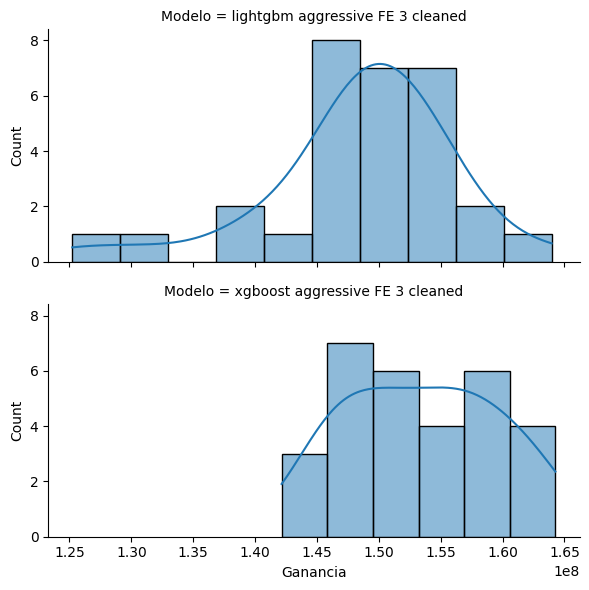

Ganancia media del modelo lightgbm aggressive FE 3 cleaned: 148525999.99999997
Ganancia media del modelo xgboost aggressive FE 3 cleaned: 153451666.6666667

Resultado del test estadístico Mann-Whitney U:
Estadístico U = 292.5
P-valor = 0.010138375705496106
Rechazamos la hipótesis nula. Hay evidencia estadística de que la distribución de xgboost aggressive FE 3 cleaned es mayor que la de lightgbm aggressive FE 3 cleaned.


In [19]:
model_a = "lightgbm aggressive FE 3 cleaned"
model_b = "xgboost aggressive FE 3 cleaned"

plot_comparisons(model_a, results_best_lgbm_fe3_c, 
                                   model_b, results_best_xgb)

**Modelo xgboost Aggressive FE 3 cleaned vs. xgboost Aggressive FE 3 cleaned and reg**

Comparando modelos: xgboost aggressive FE 3 cleaned vs. xgboost aggressive FE 3 cleaned and reg


c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


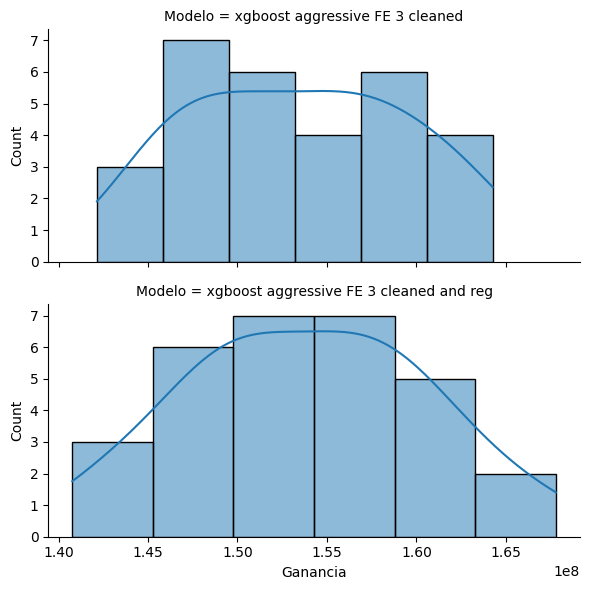

Ganancia media del modelo xgboost aggressive FE 3 cleaned: 153451666.6666667
Ganancia media del modelo xgboost aggressive FE 3 cleaned and reg: 153879444.44444445

Resultado del test estadístico Mann-Whitney U:
Estadístico U = 430.0
P-valor = 0.3865599712337615
No se rechaza la hipótesis nula. No hay evidencia suficiente para afirmar que la distribución de xgboost aggressive FE 3 cleaned and reg es mayor que la de xgboost aggressive FE 3 cleaned.


In [12]:
model_a = "xgboost aggressive FE 3 cleaned"
model_b = "xgboost aggressive FE 3 cleaned and reg"

plot_comparisons(model_a, results_best_xgb, 
                                   model_b, results_best_xgb_reg)

____

## Predicciones para Kaggle

Datos a predecir usando el modelo elegido

En este caso:

xgboost aggressive FE 3 cleaned (sin optimizar regularización)

In [37]:
to_drop # segun entrenamiento del pipeline

['payroll_slope_1_cliente_antiguedad',
 'cuenta_corriente_slope_1_cliente_antiguedad',
 'visa_consumo_slope_1_cliente_antiguedad',
 'comisiones_mantenimiento_slope_1_cliente_antiguedad',
 'comisiones_otras_slope_1_cliente_antiguedad',
 'payroll_slope_1_foto_mes',
 'cuenta_corriente_slope_1_foto_mes',
 'visa_consumo_slope_1_foto_mes',
 'comisiones_mantenimiento_slope_1_foto_mes',
 'comisiones_otras_slope_1_foto_mes',
 'Master_fultimo_cierre',
 'Visa_fultimo_cierre',
 'cprestamos_personales',
 'mprestamos_personales']

Preparación del X_kaggle

Partiendo del df de data usado en el pipeline de train

In [38]:
data

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,comisiones_mantenimiento_slope_2_foto_mes_10tile,comisiones_mantenimiento_slope_3_foto_mes_10tile,comisiones_otras_slope_1_foto_mes_10tile,comisiones_otras_slope_2_foto_mes_10tile,comisiones_otras_slope_3_foto_mes_10tile,ratio_saldo_margen_10tile,total_comisiones_cliente_10tile,transacciones_totales_tarjetas_10tile,delta_debito_vs_credito_10tile,indicador_banca_digital_10tile
0,1128309822,202102,1,0,0,44,68,2659.60,8862.12,2641.37,...,9,2,3,7,9,1,10,2,7,1
1,606189310,202102,1,0,0,48,61,2697.63,35957.55,2687.24,...,9,10,10,10,10,2,10,2,7,1
2,624696887,202102,1,0,0,62,59,4498.27,88573.39,2703.46,...,4,5,7,4,2,10,10,2,7,1
3,1324320343,202102,1,0,0,28,39,2777.98,8153.01,2777.04,...,6,8,9,5,3,1,10,2,7,1
4,770236409,202102,1,0,0,52,124,3210.98,28548.03,3102.91,...,10,2,3,7,4,10,10,2,7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981941,287385592,202104,1,0,0,64,180,-2062.70,10252.34,973.34,...,4,3,6,2,9,4,5,9,10,10
981942,1070171132,202104,1,0,0,31,84,7424.01,76160.14,1874.92,...,8,8,4,9,9,9,7,5,10,10
981943,1080005276,202104,1,0,0,34,80,7449.61,141623.05,1211.90,...,4,3,6,10,1,7,6,5,10,10
981944,954640364,202104,1,0,0,33,93,896.98,5887.66,651.85,...,4,6,8,5,6,10,4,7,10,10


In [39]:
mes_kaggle = 202106

X_kaggle = data.loc[data['foto_mes'] == mes_kaggle]

# dropping variables según pipeline en train
X_kaggle = X_kaggle.drop(columns=['clase_ternaria'] + to_drop)

# imputación usando último imputer ajustado con X_train
X_kaggle_imp = pd.DataFrame(imp_median.transform(X_kaggle), columns=X_kaggle.columns)

# modificando tipo de variables según las categóricas del X_train
for col in categorical_features:
    X_kaggle_imp[col] = X_kaggle_imp[col].astype('category')

numero_de_cliente = X_kaggle['numero_de_cliente']

In [12]:
X_kaggle

,numero_de_cliente,foto_mes,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,...,comisiones_mantenimiento_slope_2_foto_mes_10tile,comisiones_mantenimiento_slope_3_foto_mes_10tile,comisiones_otras_slope_1_foto_mes_10tile,comisiones_otras_slope_2_foto_mes_10tile,comisiones_otras_slope_3_foto_mes_10tile,ratio_saldo_margen_10tile,total_comisiones_cliente_10tile,transacciones_totales_tarjetas_10tile,delta_debito_vs_credito_10tile,indicador_banca_digital_10tile
490954,1063128780,202106,1,0,0,51,86,431.58,4823.49,1369.65,...,10,9,8,8,2,5,6,4,5,1
490955,1471395924,202106,1,0,0,46,18,417.10,-24220.74,1370.13,...,5,5,9,7,6,7,6,4,5,1
490956,700744433,202106,1,0,0,48,142,710.27,29322.45,1385.79,...,6,6,9,6,4,4,6,4,5,1
490957,1327605126,202106,1,0,0,58,42,-715.02,5645.36,874.49,...,10,10,1,3,3,5,7,4,5,1
490958,585614477,202106,1,0,0,70,136,3507.71,40344.15,46.63,...,5,5,9,6,3,8,7,4,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655825,787790832,202106,1,0,0,34,101,-8400.26,-6686.63,483.28,...,4,5,6,2,7,4,4,7,8,10
655826,1222259503,202106,1,0,0,32,53,-139.27,5121.43,15.81,...,3,4,5,8,3,1,1,1,8,10
655827,437420481,202106,1,0,1,64,256,-983.77,29912.70,175.11,...,1,1,2,3,1,5,2,1,8,10
655828,1234586071,202106,1,0,1,42,52,4212.86,49734.62,939.39,...,7,7,7,8,7,4,5,2,8,10


### Predicción con varias semillas

In [42]:
# len(list(range(217163, 455783, 17*17*4))) # semillas usadas 207
# len(list(range(217163, 455783, 17*17*17))) # semillas usadas 49
len(list(range(217163, 455783, 17*17*7))) # semillas usadas 118

118

In [44]:
import warnings

# Ignorar advertencias de tipo UserWarning
warnings.filterwarnings('ignore', category=UserWarning, module='xgboost')
warnings.filterwarnings('ignore', category=UserWarning, module='pandas')

Parámetros del pipeline del modelo:

**xgboost aggressive FE 3 cleaned (sin optimizar regularización)**

In [45]:
# tomo los parámetros óptimos del modelo a trabajar
opt_params = pipeline_xgb.best_model.get_params()

opt_params.update({'n_jobs': max_jobs})

df_s_proba = pd.DataFrame()

for s in range(217163, 455783, 17*17*7): # 118 semillas
# for s in semillas:
    # nueva instancia del modelos con semilla
    model = XGBClassifier(**opt_params, seed=s)
    # entreno
    model.fit(X_train, y_train)
    # predigo proba
    y_pred_proba = model.predict_proba(X_kaggle)
    # proba baja+2
    proba_baja2 = y_pred_proba[:,2]
    df_s_proba[f'proba_{s}'] = proba_baja2

import datetime

ft = "%dT-%m-%Y%H-%M-%S"
t_now = datetime.datetime.now().strftime(ft)

test_name = pipeline_xgb.model_type+'_FE_3_118_s_probas'+t_now+'.csv'

df_s_proba.to_csv(test_name)

C:\Users\santt\AppData\Local\Temp\ipykernel_15848\1144185965.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s_proba[f'proba_{s}'] = proba_baja2
C:\Users\santt\AppData\Local\Temp\ipykernel_15848\1144185965.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s_proba[f'proba_{s}'] = proba_baja2
C:\Users\santt\AppData\Local\Temp\ipykernel_15848\1144185965.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

In [46]:
df_s_proba.head(5)

,proba_217163,proba_219186,proba_221209,proba_223232,proba_225255,proba_227278,proba_229301,proba_231324,proba_233347,proba_235370,...,proba_435647,proba_437670,proba_439693,proba_441716,proba_443739,proba_445762,proba_447785,proba_449808,proba_451831,proba_453854
0,0.005368,0.007266,0.005725,0.006383,0.005978,0.006545,0.003189,0.005297,0.004787,0.006797,...,0.003952,0.006242,0.004379,0.007507,0.006274,0.003742,0.006351,0.009451,0.008055,0.005549
1,0.008844,0.009532,0.007636,0.009855,0.009981,0.008217,0.010920,0.008234,0.006176,0.008524,...,0.010268,0.004666,0.004824,0.011422,0.007065,0.004616,0.008617,0.006827,0.010884,0.007918
2,0.010401,0.013007,0.011195,0.007733,0.011309,0.010031,0.013544,0.009987,0.013164,0.016391,...,0.009577,0.008665,0.006740,0.009613,0.009278,0.008100,0.008790,0.007556,0.008787,0.009894
3,0.009004,0.008902,0.012632,0.009744,0.007210,0.009497,0.009912,0.008888,0.013949,0.012155,...,0.010071,0.010395,0.010932,0.009160,0.010016,0.010186,0.007789,0.013491,0.009461,0.021403
4,0.000712,0.000787,0.000804,0.000694,0.000932,0.000864,0.000793,0.000712,0.000823,0.000803,...,0.000760,0.000703,0.000770,0.001262,0.000640,0.001078,0.001145,0.000585,0.000939,0.000761


**Aplicando estrategía del backtesting**

Sacando agregación de las 118 s proba: mean

Luego usando el threshold de la submission masiva en Kaggle: 0.0182

predicciones/submission

In [47]:
proba_columns = [col for col in df_s_proba.columns if col.startswith('proba_')]

# Calcular las nuevas columnas
df_s_proba['proba_mean'] = df_s_proba[proba_columns].mean(axis=1)

C:\Users\santt\AppData\Local\Temp\ipykernel_15848\270381145.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_s_proba['proba_mean'] = df_s_proba[proba_columns].mean(axis=1)


In [61]:
# thr_opt_mean = 0.019367 # del back-testing
thr_kaggle = 0.0182

# df_s_proba['prediccion'] = (df_s_proba['proba_mean'] >= thr_opt_mean).astype(int)
df_s_proba['prediccion'] = (df_s_proba['proba_mean'] >= thr_kaggle).astype(int)

df_s_proba.head(5)

,proba_217163,proba_219186,proba_221209,proba_223232,proba_225255,proba_227278,proba_229301,proba_231324,proba_233347,proba_235370,...,proba_439693,proba_441716,proba_443739,proba_445762,proba_447785,proba_449808,proba_451831,proba_453854,proba_mean,prediccion
0,0.005368,0.007266,0.005725,0.006383,0.005978,0.006545,0.003189,0.005297,0.004787,0.006797,...,0.004379,0.007507,0.006274,0.003742,0.006351,0.009451,0.008055,0.005549,0.006281,0
1,0.008844,0.009532,0.007636,0.009855,0.009981,0.008217,0.010920,0.008234,0.006176,0.008524,...,0.004824,0.011422,0.007065,0.004616,0.008617,0.006827,0.010884,0.007918,0.007738,0
2,0.010401,0.013007,0.011195,0.007733,0.011309,0.010031,0.013544,0.009987,0.013164,0.016391,...,0.006740,0.009613,0.009278,0.008100,0.008790,0.007556,0.008787,0.009894,0.009669,0
3,0.009004,0.008902,0.012632,0.009744,0.007210,0.009497,0.009912,0.008888,0.013949,0.012155,...,0.010932,0.009160,0.010016,0.010186,0.007789,0.013491,0.009461,0.021403,0.010263,0
4,0.000712,0.000787,0.000804,0.000694,0.000932,0.000864,0.000793,0.000712,0.000823,0.000803,...,0.000770,0.001262,0.000640,0.001078,0.001145,0.000585,0.000939,0.000761,0.000826,0


In [62]:
df_s_proba['prediccion'].sum()

11911

In [63]:
import datetime

ft = "%dT-%m-%Y%H-%M-%S"
t_now = datetime.datetime.now().strftime(ft)

model_name = pipeline_xgb.model_type+'_FE_3_118_s_proba_mean_thr_opt_mean'+t_now 
# el nombre está mal, debería indicar thr 0.0182

# Crear DataFrame con el número de cliente y la predicción
submission = pd.DataFrame({
    'numero_de_cliente': numero_de_cliente.values,
    'Predicted': df_s_proba['prediccion']
})

# Nombre del archivo de salida
output_file = f"predicciones_{model_name}.csv"

# Guardar el DataFrame en un archivo CSV
submission.to_csv(output_file, index=False)
print(f"Predicciones guardadas en {output_file}")

# Imprimir value counts de las predicciones
value_counts = submission['Predicted'].value_counts()
total_count = len(submission)
print("\nValue Counts:")
print(value_counts)
print("\nFrecuencia Relativa:")
print((value_counts / total_count) * 100)

Predicciones guardadas en predicciones_xgboost_FE_3_118_s_proba_mean_thr_0.016113T-10-202400-12-48.csv

Value Counts:
Predicted
0    152965
1     11911
Name: count, dtype: int64

Frecuencia Relativa:
Predicted
0    92.775783
1     7.224217
Name: count, dtype: float64


El nombre correcto del CSV elegido es:

predicciones_xgboost_FE_3_118_s_proba_mean_thr_opt_kaggle13T-10-202400-08-29